In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import re
import random
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import gc
from tqdm.auto import tqdm
import warnings
from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.cuda.amp import GradScaler, autocast

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models import create_model

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import f1_score, classification_report

warnings.filterwarnings(action='ignore')

In [ ]:
! pip install progressbar # .py 파일로 실행 시 terminal에서 설치

import urllib
import progressbar
import time

pbar = None

def show_progress(block_num, block_size, total_size):
    global pbar
    if pbar is None:
        pbar = progressbar.ProgressBar(maxval=total_size)
        pbar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        pbar.update(downloaded)
    else:
        pbar.finish()
        pbar = None

# 학습 데이터 다운로드

start = time.time()
url = 'https://share.aiconnect.kr/fake_or_real/trainFile/train.zip'
urllib.request.urlretrieve(url, 'train.zip', show_progress)
print('time : ', time.strftime('%M:%S', time.gmtime(time.time() - start)))

# 평가용 데이터 다운로드

start = time.time()
url = 'https://share.aiconnect.kr/fake_or_real/testFile/test.zip'
urllib.request.urlretrieve(url, 'test.zip', show_progress)
print('time : ', time.strftime('%M:%S', time.gmtime(time.time() - start)))

  Preparing metadata (setup.py) ... done
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12067 sha256=2b98dff280994ba081f27361104451e858312e3254359a02695284b68bc2152b
  Stored in directory: /root/.cache/pip/wheels/cd/17/e5/765d1a3112ff3978f70223502f6047e06c43a24d7c5f8ff95b
Successfully built progressbar


time :  01:48


time :  04:02


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
CFG = {
    'EPOCHS': 10,
    'SEED': 42,
    'BATCH_SIZE': 16, #32
    'IMG_SIZE': 224, #384
    'LEARNING_RATE': 1e-3, #1e-4
}

In [ ]:
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED'])

In [ ]:
!unzip -qq 'train.zip'
!unzip -qq 'test.zip'

In [ ]:
fake_images = glob.glob('train/real_images/*.png')
real_images = glob.glob('train/fake_images/*.png')
labels = [1] * len(fake_images) + [0] * len(real_images)

In [ ]:
df = pd.DataFrame()
df['img_path'] = fake_images + real_images
df['labels'] = labels

In [ ]:
count_df = df['labels'].value_counts().reset_index()

In [ ]:
count_df

index  labels
0      1   10000
1      0   10000

<BarContainer object of 2 artists>

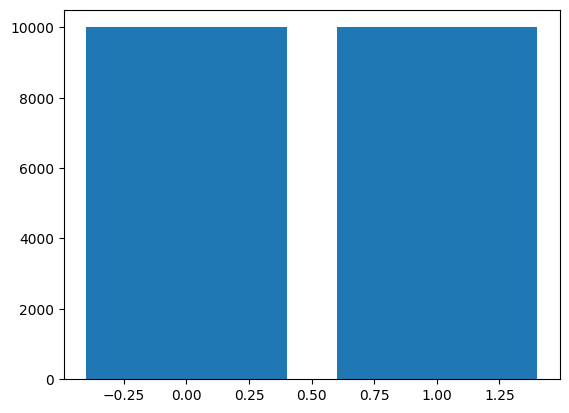

In [ ]:
plt.bar(count_df['index'], count_df['labels'])

Real 데이터와 Fake 데이터의 개수는 각각 10000개로 균형적으로 구성되어있습니다.

추가적으로 데이터 불균형 문제를 해결하기 위한 전처리는 필요없습니다.

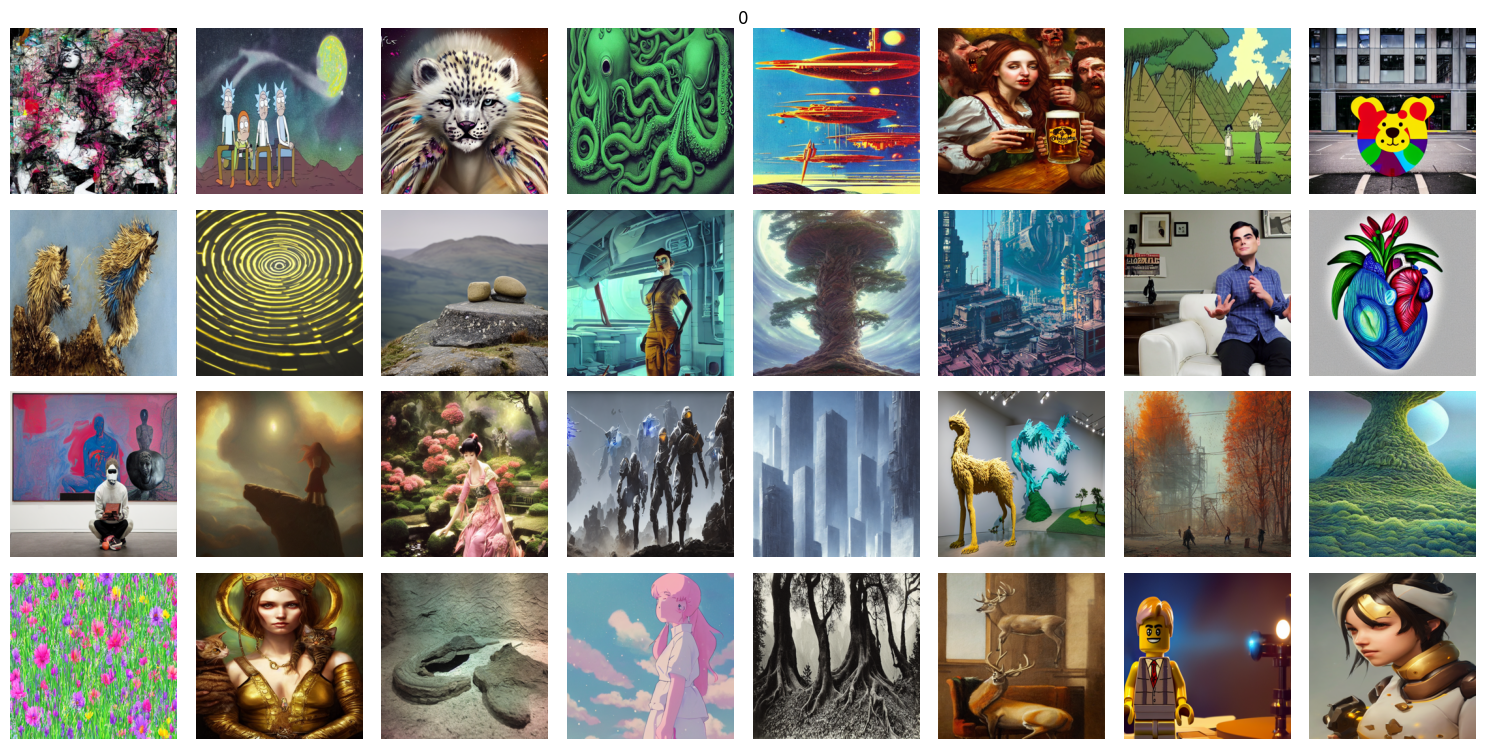

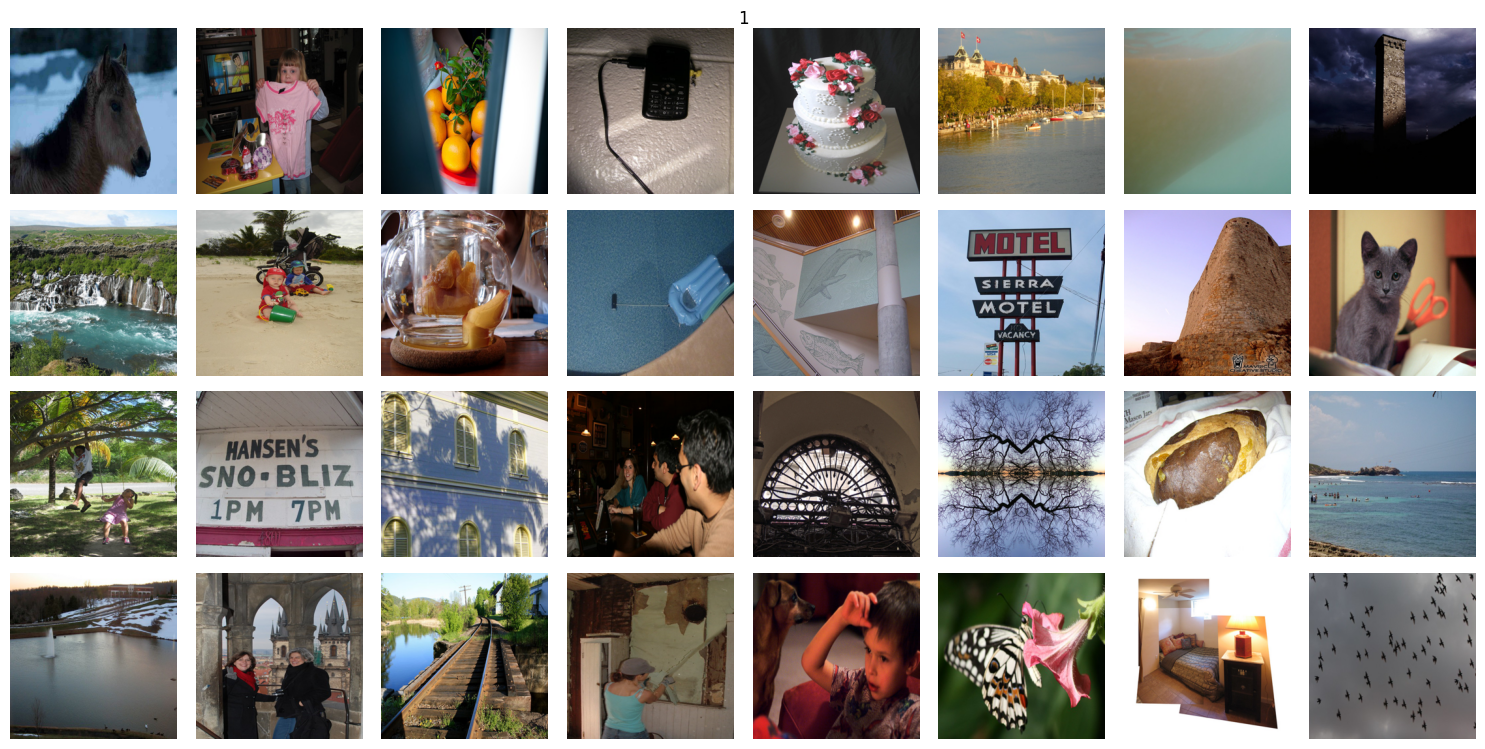

In [ ]:
def plot_images(df, label):
  species_df = df[df['labels'] == label].reset_index(drop = True)
  random_images = np.random.choice(species_df['img_path'], CFG['BATCH_SIZE'])
  plt.figure(figsize = (15, 15))
  plt.suptitle(label)
  for idx, img_path in enumerate(random_images):
    plt.subplot(8, 8, idx + 1)
    img = Image.open(img_path)
    img = img.resize((CFG['IMG_SIZE'], CFG['IMG_SIZE']))
    plt.imshow(img)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

plot_images(df, 0) # fake images
plot_images(df, 1) # real images

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, images, labels, tranforms = None):
    self.images = images
    self.labels = labels
    self.transforms = tranforms

  def __getitem__(self, index):
    img_path = self.images[index]
    image = cv2.imread(img_path)
    if self.labels is not None:
      label = self.labels[index]
      if self.transforms is not None:
        image = self.transforms(image = image)['image']
      return image, label
    else:
      if self.transforms is not None:
        image = self.transforms(image = image)['image']
        return image

  def __len__(self):
    return len(self.images)

In [ ]:
# def get_mean_std(data_dir):
#     transform = transforms.Compose([
#         transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
#         transforms.ToTensor()
#     ])

#     dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform)

#     images = [x for x, _ in dataset]
#     images = torch.stack(images, dim=0)

#     meanRGB = torch.mean(images, dim=(0, 2, 3)).numpy()
#     stdRGB = torch.std(images, dim=(0, 2, 3)).numpy()

#     meanR, meanG, meanB = meanRGB
#     stdR, stdG, stdB = stdRGB

#     print('Mean: ', meanR, meanG, meanB)
#     print('Std: ', stdR, stdG, stdB)

#     return meanR, meanG, meanB, stdR, stdG, stdB

# TrainSetDir = 'train/'
# meanR, meanG, meanB, stdR, stdG, stdB = get_mean_std(TrainSetDir)

In [ ]:
train_transforms = A.Compose([
            A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
            A.VerticalFlip(p=0.5), #p=0.5
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            # cutout
            A.CoarseDropout(max_holes=20, # Maximum number of regions to zero out. (default: 8)
                    max_height=15, # Maximum height of the hole. (default: 8)
                    max_width=15, # Maximum width of the hole. (default: 8)
                    min_holes=1, # Maximum number of regions to zero out. (default: None, which equals max_holes)
                    min_height=8, # Maximum height of the hole. (default: None, which equals max_height)
                    min_width=8, # Maximum width of the hole. (default: None, which equals max_width)
                    fill_value=0, # value for dropped pixels.
                    mask_fill_value=None, # fill value for dropped pixels in mask.
                    always_apply=False,
                    p=0.5
                   ),
            A.Normalize([0.485, 0.456,0.406],[0.229,0.224,0.225], max_pixel_value=255.0, always_apply=False, p=1.0),
            #A.Normalize(mean=(meanR, meanG, meanB), std=(stdR, stdG, stdB), max_pixel_value=255.0, always_apply=False, p=1.0),
            ToTensorV2(),
        ])

test_transforms = A.Compose([
            A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
            A.Normalize([0.485, 0.456,0.406],[0.229,0.224,0.225], max_pixel_value=255.0, always_apply=False, p=1.0),
            #A.Normalize(mean=(meanR, meanG, meanB), std=(stdR, stdG, stdB), max_pixel_value=255.0, always_apply=False, p=1.0),
            ToTensorV2(),
        ])

In [ ]:
class Model(nn.Module):
    def __init__(self, n_out = 1000, n_classes = 1):
      super(Model, self).__init__()
      #self.model = models.convnext_base(weights = models.ConvNeXt_Base_Weights.DEFAULT)

      self.model = timm.create_model('vit_base_patch16_224', pretrained = True)

      #self.model = timm.create_model('swin_small_patch4_window7_224', pretrained = True)

      #self.model = timm.create_model('efficientnet_b0_ns', pretrained = True)

      #self.model = timm.create_model('convnext_small_384_in22ft1k', pretrained = False)
      self.model.head.fc = nn.Linear(self.model.head.fc.in_features, n_classes)

      #self.model = models.efficientnet_b0(pretrained = True)
      #self.classifier = nn.Linear(n_out, n_classes) # LazyLinear, Linear

    def forward(self, x):
      x = self.model(x)
      #x = self.classifier(x)
      x = nn.Sigmoid()(x)
      return x

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
      self.patience = patience
      self.verbose = verbose
      self.counter = 0
      self.best_score = None
      self.early_stop = False
      self.val_loss_min = np.Inf
      self.delta = delta

    def __call__(self, score):
      if self.best_score is None:
        self.best_score = score
      elif score < self.best_score + self.delta:
        self.counter += 1
        print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
        if self.counter >= self.patience:
          self.early_stop = True
      else:
        self.best_score = score
        self.counter = 0

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
def MixUp(input, target, alpha=1.0):
    if CFG['ALPHA'] > 0:
        lambda_ = np.random.beta(alpha, alpha)
    else:
        lambda_ = 1

    batch_size = input.size(0)
    index = torch.randperm(batch_size)

    mixed_input = lambda_ * input + (1 - lambda_) * input[index, :]
    labels_a, labels_b = target, target[index]

    return mixed_input, labels_a, labels_b, lambda_

In [ ]:
def MixUpLoss(criterion, pred, labels_a, labels_b, lambda_):
    return lambda_ * criterion(pred, labels_a) + (1 - lambda_) * criterion(pred, labels_b)

In [ ]:
def rand_bbox(size, lam):
    W = size[2]# M x C x W x H
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [ ]:
def trains(model, train_loader, val_loader, scheduler, optimizer, criterion, device, fold = None):
  model.to(device)

  best_score = 0
  best_model = None
  fold_scores = {}
  early_stopping = EarlyStopping(patience = 5, verbose = True)
  scaler = GradScaler()
  beta = 1.0
  cutmix_prob = 0.5

  print(f'----- N_FOLD: {fold} -----')
  for epoch in range(1, CFG['EPOCHS'] + 1):
    model.train()
   train_loss = []
    for imgs, labels in tqdm(iter(train_loader)):
      imgs = imgs.float().to(device)
      labels = labels.unsqueeze(1).float().to(device)

      # # cutmix
      # r = np.random.rand(1)
      # if beta > int(0.0) and r < cutmix_prob:
      #   # generate mixed sample
      #   lam = np.random.beta(beta, beta)
      #   rand_index = torch.randperm(input.size()[0]).cuda()
      #   target_a = target
      #   target_b = target[rand_index]
      #   bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
      #   input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
      #   # adjust lambda to exactly match pixel ratio
      #   lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
      #   output = model(imgs)
      #   loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
      # # mixup
      # elif CFG['BATCH_SIZE'] % 4 == 0:
      #   imgs, labels_a, labels_b, lambda_ = MixUp(imgs, labels)
      #   ouput = model(imgs)
      #   loss = MixUpLoss(criterion, pred=output, labels_a_a=labels_a, labels_b=labels_b, lambda_=lambda_)
      # else:
      #   output = model(imgs)
      #   loss = criterion(output, labels)

      output = model(imgs)
      loss = criterion(output, labels)

      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()

      train_loss.append(loss.item())

    _val_loss, _val_score = validation(model, criterion, val_loader, device, fold=fold)
    _train_loss = np.mean(train_loss)
    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')

    if scheduler is not None:
      scheduler.step(_val_score)

    if best_score < _val_score:
      best_score = _val_score
      best_model = model

    stop = early_stopping(_val_score)
    if stop:
      break

  # save model weights
  PATH = f'./fold{fold}_best_model_weights.pt'
  torch.save(best_model.state_dict(), PATH)

  print('Fold {} Best val_score: {:.5f}'.format(fold, best_score))
  fold_scores[fold] = best_score

  return best_model

In [ ]:
def validation(model, criterion, val_loader, device, fold=None):
    model.eval()
    val_loss, val_score = [], []
    preds, true_labels = [], []

    with torch.no_grad():
      for imgs, labels in tqdm(iter(val_loader)):
        imgs = imgs.float().to(device)
        labels = labels.unsqueeze(1).float().to(device)

        pred = model(imgs)
        loss = criterion(pred, labels)

        #preds += pred.argmax(1).detach().cpu().numpy().tolist()
        #true_labels += labels.detach().cpu().numpy().tolist()
        pred = (pred >= 0.5).float()
        f1 = f1_score(labels.cpu().numpy(), pred.cpu().numpy())
        val_loss.append(loss.item())
        val_score.append(f1)

        # ensemble
        #preds.append(pred)
        #true_labels.append(labels)

    _val_loss = np.mean(val_loss)
    _val_score = np.mean(val_score)

    #preds = torch.cat(preds, 0)
    #true_labels = torch.cat(true_labels, 0)
    #preds = (preds >= 0.5).float()
    #_val_score = f1_score(true_labels.detach().cpu().numpy(), preds.detach().cpu().numpy(), average='macro')

    return _val_loss, _val_score

In [ ]:
def inference(model, test_loader, device, fold=None):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)

            pred = model(imgs)

            #preds += pred.argmax(1).detach().cpu().numpy().tolist()
            pred = (pred.cpu().numpy() >= 0.5).float()
            preds.append(pred)

    #preds = torch.cat(preds, 0)
    #preds = (preds >= 0.5).float()
    return preds

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, channels):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.channels = channels

        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.channels = channels

        self.main = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

batch_size = 64
num_epochs = 10
learning_rate = 0.001

generator = Generator()
discriminator = Discriminator()

loss_function = nn.BCELoss()
generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

real_dataset = CustomDataset(df['img_path'][df['labels'] == 1].values, df['labels'][df['labels'] == 1].values, train_transforms)
real_loader = DataLoader(real_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

# Train the GAN model
for epoch in range(num_epochs):
    for i, real_images in enumerate(real_loader):
        fake_images = real_images.repeat(len(real_loader), 1, 1, 1)

        # Train the discriminator
        discriminator.zero_grad()
        real_labels = torch.ones(len(real_images))
        fake_labels = torch.zeros(len(fake_images))
        real_outputs = discriminator(real_images)
        fake_outputs = discriminator(fake_images)
        discriminator_loss = (loss_function(real_outputs, real_labels) + loss_function(fake_outputs, fake_labels)) / 2
        discriminator_loss.backward()
        discriminator_optimizer.step()

        # Train the generator
        generator.zero_grad()
        fake_outputs = discriminator(fake_images)
        generator_loss = loss_function(fake_outputs, real_labels)
        generator_loss.backward()
        generator_optimizer.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(real_loader)}], Discriminator Loss: {discriminator_loss.item()}, Generator Loss: {generator_loss.item()}")

# Generate 1000 fake images
generated_images = []
for _ in range(1000):
    # Generate a fake image using the generator
    fake_image = generator(torch.randn(1, 100)).detach().squeeze()

    # Denormalize the generated image
    fake_image = fake_image * 0.5 + 0.5

    # Convert the image tensor to a numpy array
    fake_image = fake_image.permute(1, 2, 0).numpy()

    # Resize the fake image to 224x224
    fake_image = cv2.resize(fake_image, (224, 224))

    # Append the generated image to the list
    generated_images.append(fake_image)

# Convert the list of generated images to a numpy array
generated_images = np.array(generated_images)

In [ ]:
generated_images

In [ ]:
os.makedirs('./output/', exist_ok=True)

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [ ]:
skf = KFold(n_splits = 5, shuffle = True)
fold_preds = []
for fold, (train_idx, val_idx) in enumerate(skf.split(df.index)):
  X_train = df.loc[train_idx]
  X_valid = df.loc[val_idx]

  train_dataset = CustomDataset(X_train['img_path'].values, X_train['labels'].values, train_transforms)
  train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=2, worker_init_fn=seed_worker, generator=g)

  valid_dataset = CustomDataset(X_valid['img_path'].values, X_valid['labels'].values, test_transforms)
  valid_loader = DataLoader(valid_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)

  test_df = pd.DataFrame()
  test_df['img_path'] = glob.glob('test/images/*.png')
  test_dataset = CustomDataset(test_df['img_path'].values, None, test_transforms)
  test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

  model = Model()
  criterion = nn.BCELoss() # nn.BCELoss(), nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)
  #scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0) #T_max=50
  #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

  trained_model = trains(model, train_loader, valid_loader, scheduler, optimizer, criterion, device, fold = fold)
  preds = inference(trained_model, test_loader, device, fold = fold)

  fold_preds.append(preds)

  sample_submission = pd.read_csv('/content/test/sample_submission.csv')
  sample_submission['label'] = preds
  sample_submission.to_csv(f'./output/fold{fold}.csv', index=False)

----- N_FOLD: 0 -----


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.21648] Val Loss : [13.05946] Val Weighted F1 Score : [0.33177]


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
out = []

cols = list(zip(*fold_preds))
for c in cols:
  most = collections.Counter(c).most_common()[0][0]
  out.append(most)

sample_submission = pd.read_csv('/content/test/sample_submission.csv')
sample_submission['label'] = out
sample_submission.to_csv('./output/fold_voting.csv', index=False)

In [ ]:
|preds

In [ ]:
fold = 'None'

train_dataset = CustomDataset(df['img_path'].values, df['labels'].values, train_transforms)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)

valid_dataset = CustomDataset(df['img_path'].values, df['labels'].values, test_transforms)
valid_loader = DataLoader(valid_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)

test_df = pd.DataFrame()
test_df['img_path'] = glob.glob('test/images/*.png')
test_dataset = CustomDataset(test_df['img_path'].values, None, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

model = Model()
criterion = nn.BCELoss() # nn.BCELoss(), nn.BCEWithLogitsLoss(), nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0) #T_max=50
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

trained_model = trains(model, train_loader, valid_loader, scheduler, optimizer, criterion, device, fold = fold)
preds = inference(trained_model, test_loader, device, fold = fold)

----- N_FOLD: None -----


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.27690] Val Loss : [0.10779] Val Weighted F1 Score : [0.95703]


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.18664] Val Loss : [0.09392] Val Weighted F1 Score : [0.96289]


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.15642] Val Loss : [0.12373] Val Weighted F1 Score : [0.95059]
EarlyStopping counter: 1 out of 5


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.12632] Val Loss : [0.09059] Val Weighted F1 Score : [0.96139]
Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
EarlyStopping counter: 2 out of 5


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.08487] Val Loss : [0.04464] Val Weighted F1 Score : [0.98445]


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.07233] Val Loss : [0.04219] Val Weighted F1 Score : [0.98192]
EarlyStopping counter: 1 out of 5


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.06970] Val Loss : [0.03402] Val Weighted F1 Score : [0.98737]


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.05941] Val Loss : [0.04566] Val Weighted F1 Score : [0.97866]
EarlyStopping counter: 1 out of 5


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.05657] Val Loss : [0.02761] Val Weighted F1 Score : [0.98953]


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.05180] Val Loss : [0.02137] Val Weighted F1 Score : [0.99232]
Fold None Best val_score: 0.99232


  0%|          | 0/3647 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
preds = inference(trained_model, test_loader, device, fold = fold)

  0%|          | 0/3647 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
preds